This notebook saves to a .csv file only the cases where the model failed to make a correct prediction

In [10]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [11]:
msr_data = pd.read_csv('../data/msr/msr_data.csv')
new_data = pd.read_csv('../data/new/new_data.csv')
print(msr_data.shape, new_data.shape)

(2806, 3) (1632, 3)


In [12]:
msr_no_duplicates = msr_data.drop_duplicates()
new_no_duplicates = new_data.drop_duplicates()
print(msr_no_duplicates.shape ,new_no_duplicates.shape)

(2771, 3) (1464, 3)


In [13]:
def preprocess(token):
    token = str(token) 
    token_lowered = token.lower()
    
    #token_lowered = re.sub(r'(\brow\b)|(\btable\b)|(\binsert\b)|(\bid\b)', 'dbms', token_lowered)
    
    url_pattern = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    token_url = re.sub(url_pattern, 'urllink', token_lowered)
    
    date_pattern = '([12]\d{3}/(0[1-9]|1[0-2])/(0[1-9]|[12]\d|3[01]))|([12]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01]))|([12]\d{3}/(0[1-9]|1[0-2])/(0[1-9]|[12]\d|3[01]))'
    token_dates = re.sub(date_pattern, 'date', token_url)
    
    ip_pattern = '(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.){3}([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])'
    token_ip = re.sub(ip_pattern, ' ipaddrezz ', token_dates)
    
    token_num = re.sub(r'\b[0-9]+\b', ' ', token_ip)
    
    special_character_pattern = '[^A-Za-z0-9]+'
    token_char = re.sub(special_character_pattern, ' ', token_num)
    
    return token_char

In [14]:
y_msr = msr_no_duplicates['flaky']
X_msr = msr_no_duplicates['token'].values.astype('U')

In [15]:
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_validate(pipeline, X_msr, y_msr, 
                        cv=cv, return_estimator=True, scoring=['f1',
                                                               'accuracy',
                                                               'precision',
                                                               'recall'])

In [16]:
scores

{'fit_time': array([2.97004867, 1.6984973 , 1.39062476, 1.28843999, 1.28944826]),
 'score_time': array([0.26562762, 0.23910022, 0.21875644, 0.19099593, 0.20570922]),
 'estimator': (Pipeline(steps=[('countvectorizer', CountVectorizer()),
                  ('multinomialnb', MultinomialNB())]),
  Pipeline(steps=[('countvectorizer', CountVectorizer()),
                  ('multinomialnb', MultinomialNB())]),
  Pipeline(steps=[('countvectorizer', CountVectorizer()),
                  ('multinomialnb', MultinomialNB())]),
  Pipeline(steps=[('countvectorizer', CountVectorizer()),
                  ('multinomialnb', MultinomialNB())]),
  Pipeline(steps=[('countvectorizer', CountVectorizer()),
                  ('multinomialnb', MultinomialNB())])),
 'test_f1': array([0.91778203, 0.93761141, 0.93900185, 0.91262136, 0.92164179]),
 'test_accuracy': array([0.92252252, 0.93693694, 0.94054054, 0.91891892, 0.92432432]),
 'test_precision': array([0.96      , 0.95985401, 0.95849057, 0.97107438, 0.976284

In [17]:
y_new = new_no_duplicates['flaky']
X_new = new_no_duplicates['token'].values.astype('U')

In [18]:
classifier = scores['estimator'][0]
new_preds = classifier.predict(X_new)
print(classification_report(y_new, new_preds))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       734
           1       0.63      0.63      0.63       730

    accuracy                           0.63      1464
   macro avg       0.63      0.63      0.63      1464
weighted avg       0.63      0.63      0.63      1464



In [19]:
new_preds

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [20]:
new_no_duplicates['prediction'] = new_preds

c:\users\aian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
wrong_predictions = new_no_duplicates.query('flaky != prediction')

In [22]:
wrong_predictions['project'].value_counts()

hadoop          130
okhttp           65
spring-boot      64
ambari           52
alluxio          40
logback          28
hector           26
httpcore         21
http-request     18
commons-exec     16
wroj4            15
dubbo            15
jackrabbit        9
wildfly           6
activiti          6
orbit             6
achilles          5
websocket         5
undertow          4
zxing             3
ninja             2
togglz            2
elasticjob        2
handlebars        1
Name: project, dtype: int64

In [63]:
def plot_word_count(data, n):
    counter = CountVectorizer()
    bow = counter.fit_transform(data)
    sparse_matrix = pd.DataFrame(bow.toarray(), columns = counter.get_feature_names())
    counts = sparse_matrix.sum().sort_values(ascending=False)

    sns.barplot(x=counts.index[:n], y=counts.values[:n], palette='Blues_d')
    plt.xticks(rotation=90)
    plt.title('Word frequency in corpus')

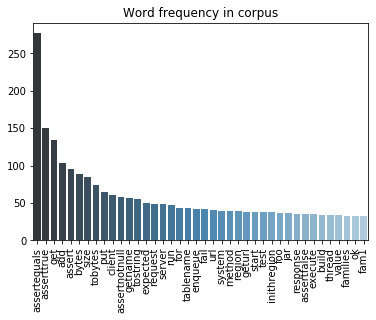

In [64]:
plot_word_count(wrong_predictions['token'], n=40)

In [65]:
wrong2 = pd.read_csv('wrong_predicitons.csv')

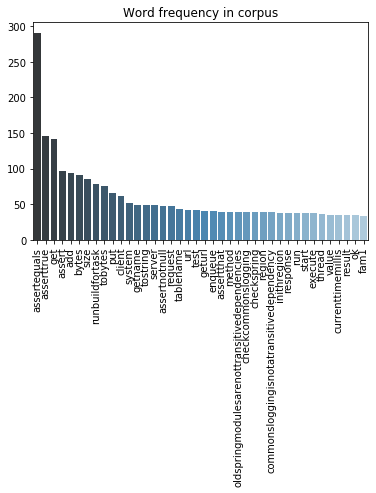

In [66]:
plot_word_count(wrong2['token'], n=40)